# Wealth of Nations – Economic and Social Indicators Across Countries

This notebook summarizes the main steps and findings of the project:

- Load the cleaned country-level dataset
- Explore descriptive statistics and correlations
- Visualize key relationships between GDP per capita and social indicators
- Estimate multiple regression models (global and by continent)
- Use K-means clustering to identify “development profiles” of countries


## 1. Setup and Data Loading

We use the cleaned dataset `data/clean_country_data.csv`, which already contains:

- `gdp_per_capita` (target variable)
- `life_expectancy` (average of male and female)
- `internet_users`, `fertility`, `unemployment`, `urban_population_growth`
- `continent`, `region`, `name`, `iso2`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")
sns.set_context("talk")

df = pd.read_csv("data/clean_country_data.csv")
df.head()


,name,iso2,region,gdp,gdp_per_capita,population,life_expectancy_male,life_expectancy_female,life_expectancy,fertility,internet_users,unemployment,urban_population_growth,secondary_school_enrollment_female,secondary_school_enrollment_male,co2_emissions,refugees,continent
0,Afghanistan,AF,Southern Asia,20514.0,551.9,38928.0,62.8,65.8,64.3,4.6,13.5,11.2,4.0,40.0,70.1,NaN,2826.4,Asia
1,Albania,AL,Southern Europe,15059.0,5223.8,2878.0,76.7,80.1,78.4,1.6,71.8,12.8,1.8,95.7,95.2,4.3,4.3,Europe
2,Algeria,DZ,Northern Africa,173757.0,4114.7,43851.0,75.4,77.8,76.6,3.0,49.0,11.5,2.9,101.5,97.8,130.5,99.5,Africa
3,Angola,AO,Middle Africa,105902.0,3437.3,32866.0,57.8,63.4,60.6,5.6,14.3,6.8,4.7,39.7,61.8,18.0,70.1,Africa
4,Antigua And Barbuda,AG,Caribbean,1611.0,16727.0,98.0,75.7,77.9,76.8,2.0,76.0,NaN,0.1,109.1,113.3,NaN,0.2,North America


## 2. Code (Correlations with GDP per capita)

Here we  look at the varibales that are highly correlated with the main variable of interest


In [2]:
corr_cols = [
    "gdp_per_capita",
    "life_expectancy",
    "fertility",
    "internet_users",
    "unemployment",
    "urban_population_growth",
]

corr = df[corr_cols].corr()
corr["gdp_per_capita"]


gdp_per_capita             1.000000
life_expectancy            0.646959
fertility                 -0.491401
internet_users             0.679560
unemployment              -0.173425
urban_population_growth   -0.274104
Name: gdp_per_capita, dtype: float64

## 3. Visualizing Key Relationships

We visualize how GDP per capita relates to life expectancy, internet usage, and fertility.  
Points are colored by continent.

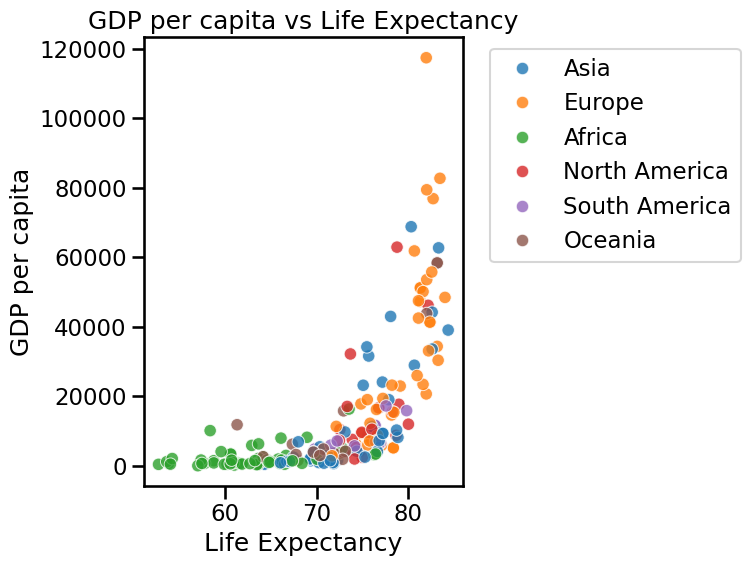

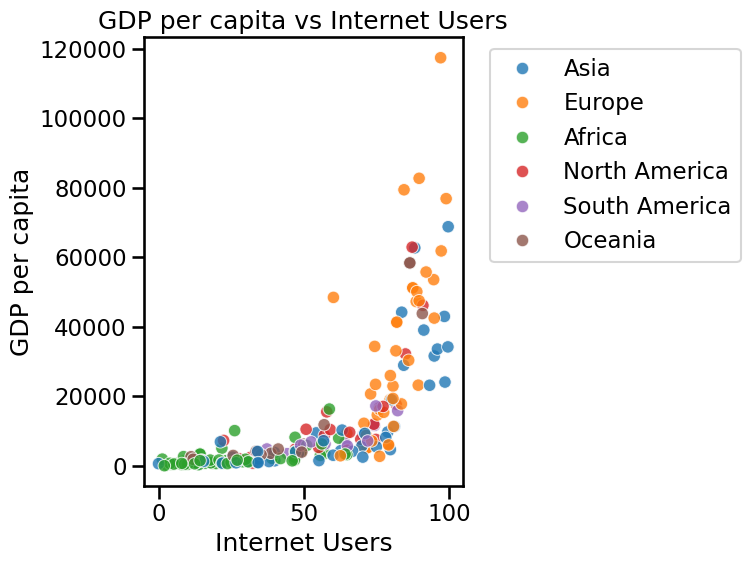

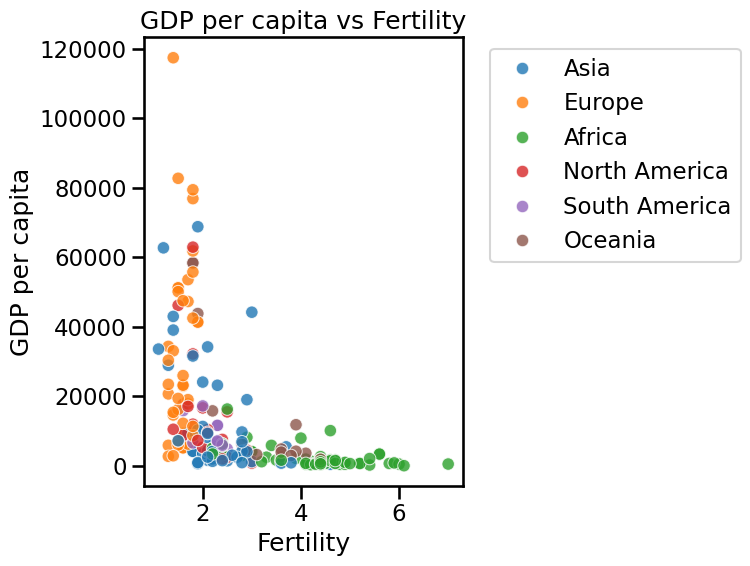

In [3]:
def scatter_gdp_vs(var, df_plot=None):
    if df_plot is None:
        df_plot = df
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_plot,
        x=var,
        y="gdp_per_capita",
        hue="continent",
        alpha=0.8,
    )
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel("GDP per capita")
    plt.title(f"GDP per capita vs {var.replace('_', ' ').title()}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

for v in ["life_expectancy", "internet_users", "fertility"]:
    scatter_gdp_vs(v)


## 4. ## 4. Global Multiple Regression

We estimate a linear model of GDP per capita on several predictors:

\[
\text{GDPpc}_i = \beta_0 + \beta_1 \cdot \text{life\_expectancy}_i
+ \beta_2 \cdot \text{internet\_users}_i
+ \beta_3 \cdot \text{fertility}_i
+ \beta_4 \cdot \text{unemployment}_i
+ \beta_5 \cdot \text{urban\_population\_growth}_i + \varepsilon_i
\]


In [4]:
reg_cols = [
    "life_expectancy",
    "internet_users",
    "fertility",
    "unemployment",
    "urban_population_growth",
]

reg_df = df.dropna(subset=["gdp_per_capita"] + reg_cols).copy()
X = reg_df[reg_cols]
X = sm.add_constant(X)
y = reg_df["gdp_per_capita"]

global_model = sm.OLS(y, X).fit()
global_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         gdp_per_capita   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     44.17
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           7.61e-30
Time:                        18:34:48   Log-Likelihood:                -2082.4
No. Observations:                 191   AIC:                             4177.
Df Residuals:                     185   BIC:                             4196.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -9.917e+04   2.22e+04     -4.475      0.000   -1.43e+05   -5.55e+04
life_expectancy          1097.4034    276.814      3.964      0.000     551.286    1643.521
internet_users            415.7593     62.641      6.637      0.000     292.176     539.343
fertility                5068.9981   1704.016      2.975      0.003    1707.197    8430.799
unemployment             -417.7859    181.874     -2.297      0.023    -776.600     -58.971
urban_population_growth   276.8708    747.106      0.371      0.711   -1197.072    1750.814
==============================================================================
Omnibus:                       99.320   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              566.110
Skew:                           1.933   Prob(JB):                    1.18e-123
Kurtosis:                      10.496   Cond. No.                     2.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 5. ### Interpretation (Global Model)

- The R-squared tells us how much of the variation in GDP per capita is explained by the predictors.
- Coefficients on **life expectancy** and **internet users** are positive and statistically significant.
- **Fertility** tends to have a negative association with GDP per capita.
- **Unemployment** and **urban population growth** contribute less to the overall explanatory power.


## 5. Regression by Continent

Next, we fit the same model separately for each continent to see whether the relationships differ across regions.


In [5]:
continents = sorted(df["continent"].dropna().unique())
results_by_continent = {}

for cont in continents:
    sub = df[df["continent"] == cont].dropna(subset=["gdp_per_capita"] + reg_cols)
    if len(sub) < 8:  # avoid very tiny samples
        continue
    X_sub = sm.add_constant(sub[reg_cols])
    y_sub = sub["gdp_per_capita"]
    m = sm.OLS(y_sub, X_sub).fit()
    results_by_continent[cont] = m
    print(f"\n=== {cont} ===")
    print(m.summary().tables[1])



=== Africa ===
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1190.5698   6244.243      0.191      0.850   -1.14e+04    1.37e+04
life_expectancy            14.0072     75.758      0.185      0.854    -138.235     166.249
internet_users             65.7579     26.436      2.487      0.016      12.634     118.882
fertility                -472.5738    590.838     -0.800      0.428   -1659.908     714.760
unemployment               33.1311     64.171      0.516      0.608     -95.826     162.088
urban_population_growth   112.6856    365.903      0.308      0.759    -622.624     847.995

=== Asia ===
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.414e+05   4.25e+04     

## 6. K-Means Clustering

Finally, we use K-means clustering to group countries into development
profiles based on:

- gdp_per_capita
- life_expectancy
- internet_users
- fertility
- unemployment

We standardize the features first and then fit a K-means model with 4 clusters.

In [6]:
cluster_cols = [
    "gdp_per_capita",
    "life_expectancy",
    "internet_users",
    "fertility",
    "unemployment",
]

clust_df = df.dropna(subset=cluster_cols).copy()
X_clust = clust_df[cluster_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clust_df["cluster"] = kmeans.fit_predict(X_scaled)

clust_df[
    [
        "name",
        "continent",
        "gdp_per_capita",
        "life_expectancy",
        "internet_users",
        "fertility",
        "unemployment",
        "cluster",
    ]
].head()


,name,continent,gdp_per_capita,life_expectancy,internet_users,fertility,unemployment,cluster
0,Afghanistan,Asia,551.9,64.3,13.5,4.6,11.2,0
1,Albania,Europe,5223.8,78.4,71.8,1.6,12.8,3
2,Algeria,Africa,4114.7,76.6,49.0,3.0,11.5,3
3,Angola,Africa,3437.3,60.6,14.3,5.6,6.8,0
5,Argentina,South America,11687.6,76.4,74.3,2.3,10.4,3


In [7]:
cluster_summary = clust_df.groupby("cluster")[cluster_cols].mean()
cluster_summary


,gdp_per_capita,life_expectancy,internet_users,fertility,unemployment
cluster,,,,,
0,1631.473469,62.755102,17.483673,4.587755,5.032653
1,47531.278947,81.078947,89.060526,1.660526,5.102632
2,5087.736000,69.328000,49.400000,2.760000,18.160000
3,7902.487342,74.508861,60.017722,2.187342,6.425316


### 6.1 Visualizing Clusters

We can plot GDP per capita vs life expectancy and color points by
their cluster assignment.

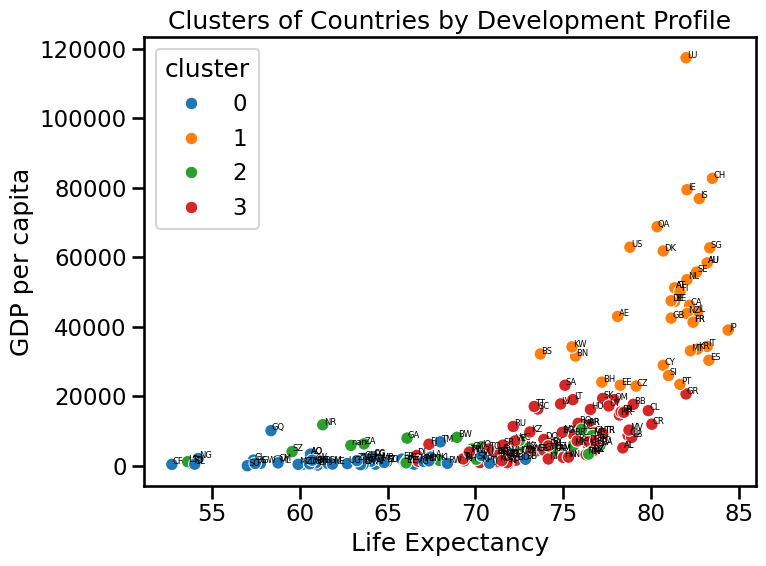

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=clust_df,
    x="life_expectancy",
    y="gdp_per_capita",
    hue="cluster",
    palette="tab10",
)

for _, row in clust_df.iterrows():
    plt.text(
        row["life_expectancy"] + 0.05,
        row["gdp_per_capita"] + 50,
        row["iso2"],
        fontsize=6,
    )

plt.xlabel("Life Expectancy")
plt.ylabel("GDP per capita")
plt.title("Clusters of Countries by Development Profile")
plt.tight_layout()
plt.show()


## 7. Summary of Findings

- Countries with higher **life expectancy** and higher **internet use** tend to have much higher GDP per capita.
- **Higher fertility** is generally associated with lower income per person.
- The strength and direction of these relationships vary by continent, suggesting that regional context matters.
- **K-means clustering** reveals distinct development profiles such as:
  - High-income digital economies,
  - Low-income high-fertility economies,
  - Intermediate transition economies.

